# Concise Implementation of Recurrent Neural Networks

Like most of our from-scratch implementations,
:numref:`sec_rnn-scratch` was designed 
to provide insight into how each component works.
But when you are using RNNs every day 
or writing production code,
you will want to rely more on libraries
that cut down on both implementation time 
(by supplying library code for common models and functions)
and computation time 
(by optimizing the heck out of these library implementations).
This section will show you how to implement 
the same language model more efficiently
using the high-level API provided 
by your deep learning framework.
We begin, as before, by loading 
*The Time Machine* dataset.


In [1]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using Downloads
using StatsBase
using Plots
using CUDA, cuDNN

  Activating project at `/workspace/d2l-julia/d2lai`
[ Info: Precompiling d2lai [749b8817-cd67-416c-8a57-830ea19f3cc4] (cache misses: include_dependency fsize change (2))



## Defining the Model

We define the following class
using the RNN implemented
by high-level APIs.


In [5]:
num_hiddens = 32 
input_size = 28
rnn = Flux.RNN(input_size => num_hiddens, return_state = true)

RNN(28 => 32, tanh)  # 1_952 parameters

Inheriting from the `AbstractRNNClassifier` class in :numref:`sec_rnn-scratch`, 
the following `RNNLM` class defines a complete RNN-based language model.
Note that we need to create a separate fully connected output layer.

In [6]:
struct RNNLM{N,R,A} <: d2lai.AbstractRNNClassifier 
    net::N 
    rnn::R 
    args::A
end

Flux.@layer RNNLM trainable = (net, rnn)
function RNNLM(rnn::Flux.RNN, num_hiddens::Int, vocab_size::Int)
    net = Dense(num_hiddens => vocab_size)
    return RNNLM(net, rnn, (num_hiddens = num_hiddens, vocab_size = vocab_size))
end

function d2lai.output_layer(m::RNNLM, out)
    m.net(out)
end

function (m::RNNLM)(x)
    out = m.rnn(x)[1]
    return d2lai.output_layer(m, out)
end


## Training and Predicting

Before training the model, let's make a prediction 
with a model initialized with random weights.
Given that we have not trained the network, 
it will generate nonsensical predictions.


In [13]:
num_hiddens = 32
data = d2lai.TimeMachine(1024, 32) |> f64
rnn = Flux.RNN(length(data.vocab) => num_hiddens, return_state = true)
model = RNNLM(rnn, num_hiddens, length(data.vocab)) |> f64
prefix = "it has"
d2lai.prediction(prefix, model, data.vocab, 20, state = zeros(num_hiddens))

"it hasnfjqoqvsoqvszqk<unk>zbgs"

[ Info: Train Loss: 2.8086967, Val Loss: 2.8176572
[ Info: Train Loss: 2.5578668, Val Loss: 2.5525599
[ Info: Train Loss: 2.4050918, Val Loss: 2.4460049
[ Info: Train Loss: 2.316194, Val Loss: 2.368135
[ Info: Train Loss: 2.2381124, Val Loss: 2.332166
[ Info: Train Loss: 2.1993399, Val Loss: 2.3082745
[ Info: Train Loss: 2.1650236, Val Loss: 2.2931821
[ Info: Train Loss: 2.1162374, Val Loss: 2.2517207
[ Info: Train Loss: 2.1146615, Val Loss: 2.2625127
[ Info: Train Loss: 2.0888648, Val Loss: 2.2390275
[ Info: Train Loss: 2.0716052, Val Loss: 2.230474
[ Info: Train Loss: 2.0240247, Val Loss: 2.2290487
[ Info: Train Loss: 2.0295258, Val Loss: 2.2020535
[ Info: Train Loss: 1.9899576, Val Loss: 2.1624563
[ Info: Train Loss: 2.004797, Val Loss: 2.1773639
[ Info: Train Loss: 1.9721513, Val Loss: 2.1735885
[ Info: Train Loss: 1.9659573, Val Loss: 2.1581883
[ Info: Train Loss: 1.9484462, Val Loss: 2.1393445
[ Info: Train Loss: 1.930977, Val Loss: 2.1594217
[ Info: Train Loss: 1.9451939, Val Lo

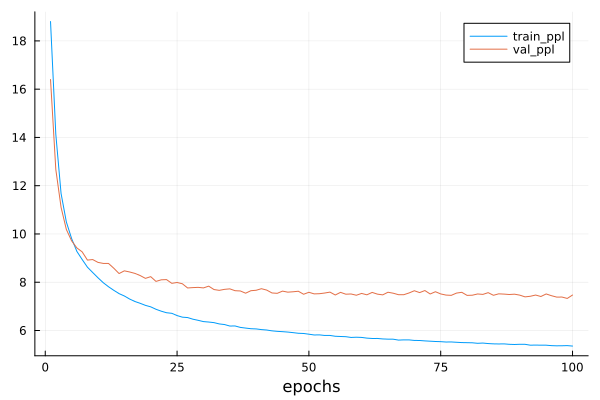

(RNNLM{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, RNN{true, RNNCell{typeof(tanh), Matrix{Float32}, Matrix{Float32}, Vector{Float32}}}, @NamedTuple{num_hiddens::Int64, vocab_size::Int64}}(Dense(32 => 28), RNN(28 => 32, tanh), (num_hiddens = 32, vocab_size = 28)), (val_loss = Float32[2.0083926, 1.9724069, 2.137811, 1.8953362, 2.039872], val_acc = nothing))

In [14]:
opt = Descent(1.)
trainer = Trainer(model, data, opt; max_epochs = 100, gpu = true, board_yscale = :identity, gradient_clip_val = 1.)
m, _ = d2lai.fit(trainer)

Compared with :numref:`sec_rnn-scratch`,
this model achieves comparable perplexity,
but runs faster due to the optimized implementations.
As before, we can generate predicted tokens 
following the specified prefix string.


In [16]:
prefix = "it has"
d2lai.prediction(prefix, m, data.vocab, 20, state = zeros(num_hiddens))

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(32 => 28)     # 924 parameters
│   summary(x) = "32×1 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/3711C/src/layers/stateless.jl:60


"it has dimension of the po"


## Summary

High-level APIs in deep learning frameworks provide implementations of standard RNNs.
These libraries help you to avoid wasting time reimplementing standard models.
Moreover,
framework implementations are often highly optimized, 
  leading to significant (computational) performance gains 
  when compared with implementations from scratch.

## Exercises

1. Can you make the RNN model overfit using the high-level APIs?
1. Implement the autoregressive model of :numref:`sec_sequence` using an RNN.

